# Notebook 14: Diffusion Models

## Learning Objectives

By the end of this notebook, you will:
1. Understand the forward and reverse diffusion processes
2. Implement a noise scheduler and the training objective
3. Build a U-Net architecture for denoising
4. Train a diffusion model on MNIST
5. Implement sampling algorithms (DDPM, DDIM)

**Prerequisites**: Notebooks 01-04, 07 (CNNs)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

torch.manual_seed(42)

Using device: cuda


---
## 1. Diffusion Process Overview

Diffusion models work in two phases:

### Forward Process (Fixed)
Gradually add noise to data over T timesteps until it becomes pure noise:
$$q(x_t | x_{t-1}) = \mathcal{N}(x_t; \sqrt{1-\beta_t} x_{t-1}, \beta_t I)$$

### Reverse Process (Learned)
Learn to denoise step by step:
$$p_\theta(x_{t-1} | x_t) = \mathcal{N}(x_{t-1}; \mu_\theta(x_t, t), \sigma_t^2 I)$$

```
Forward:  x_0 (data) → x_1 → x_2 → ... → x_T (noise)
Reverse:  x_T (noise) → x_{T-1} → ... → x_0 (generated data)
```

In [2]:
# Load MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Scale to [-1, 1]
])

train_dataset = datasets.MNIST('../data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, drop_last=True)

---
## 2. Noise Schedule

The noise schedule $\{\beta_t\}_{t=1}^T$ controls how much noise is added at each step.

Key quantities:
- $\alpha_t = 1 - \beta_t$
- $\bar{\alpha}_t = \prod_{s=1}^t \alpha_s$ (cumulative product)

With these, we can sample $x_t$ directly from $x_0$:
$$x_t = \sqrt{\bar{\alpha}_t} x_0 + \sqrt{1 - \bar{\alpha}_t} \epsilon$$

where $\epsilon \sim \mathcal{N}(0, I)$

In [3]:
class NoiseScheduler:
    """Manages the noise schedule for diffusion."""
    
    def __init__(self, num_timesteps=1000, beta_start=1e-4, beta_end=0.02, device='cpu'):
        self.num_timesteps = num_timesteps
        self.device = device
        
        # Linear schedule
        self.betas = torch.linspace(beta_start, beta_end, num_timesteps, device=device)
        
        # Precompute useful quantities
        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        self.alphas_cumprod_prev = F.pad(self.alphas_cumprod[:-1], (1, 0), value=1.0)
        
        # For q(x_t | x_0)
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - self.alphas_cumprod)
        
        # For posterior q(x_{t-1} | x_t, x_0)
        self.posterior_variance = self.betas * (1.0 - self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)
    
    def add_noise(self, x_0, t, noise=None):
        """Add noise to x_0 to get x_t: q(x_t | x_0)"""
        if noise is None:
            noise = torch.randn_like(x_0)
        
        sqrt_alpha = self.sqrt_alphas_cumprod[t].view(-1, 1, 1, 1)
        sqrt_one_minus_alpha = self.sqrt_one_minus_alphas_cumprod[t].view(-1, 1, 1, 1)
        
        return sqrt_alpha * x_0 + sqrt_one_minus_alpha * noise
    
    def sample_timesteps(self, batch_size):
        """Sample random timesteps."""
        return torch.randint(0, self.num_timesteps, (batch_size,), device=self.device)

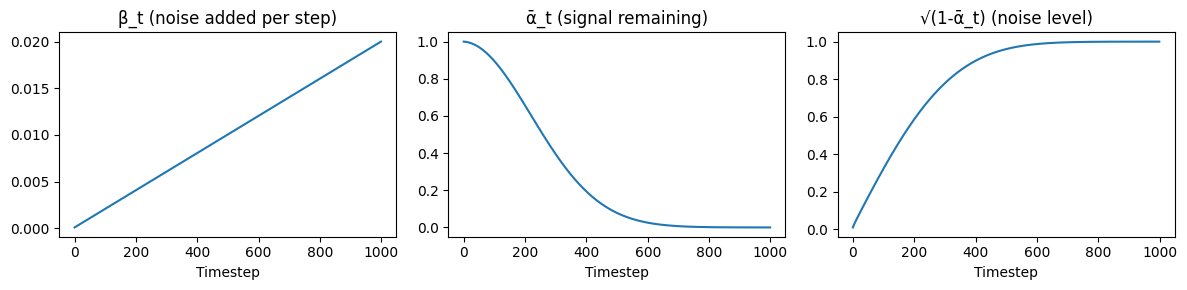

In [4]:
# Visualize the noise schedule
scheduler = NoiseScheduler(num_timesteps=1000, device=device)

fig, axes = plt.subplots(1, 3, figsize=(12, 3))

axes[0].plot(scheduler.betas.cpu())
axes[0].set_title('β_t (noise added per step)')
axes[0].set_xlabel('Timestep')

axes[1].plot(scheduler.alphas_cumprod.cpu())
axes[1].set_title('ᾱ_t (signal remaining)')
axes[1].set_xlabel('Timestep')

axes[2].plot(scheduler.sqrt_one_minus_alphas_cumprod.cpu())
axes[2].set_title('√(1-ᾱ_t) (noise level)')
axes[2].set_xlabel('Timestep')

plt.tight_layout()
plt.show()

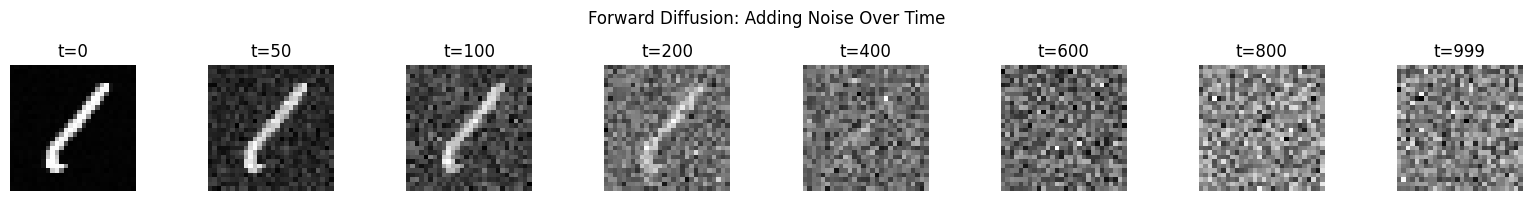

In [5]:
# Visualize forward diffusion process
x_0, _ = next(iter(train_loader))
x_0 = x_0[:1].to(device)  # Single image

timesteps = [0, 50, 100, 200, 400, 600, 800, 999]
fig, axes = plt.subplots(1, len(timesteps), figsize=(16, 2))

for ax, t in zip(axes, timesteps):
    t_tensor = torch.tensor([t], device=device)
    x_t = scheduler.add_noise(x_0, t_tensor)
    img = (x_t[0, 0].cpu() + 1) / 2  # Denormalize
    ax.imshow(img, cmap='gray')
    ax.set_title(f't={t}')
    ax.axis('off')

plt.suptitle('Forward Diffusion: Adding Noise Over Time')
plt.tight_layout()
plt.show()

---
## 3. U-Net Architecture

The denoising network predicts the noise $\epsilon$ given $x_t$ and $t$.

U-Net structure:
- **Encoder**: Downsample with residual blocks
- **Bottleneck**: Process at lowest resolution
- **Decoder**: Upsample with skip connections
- **Time embedding**: Inject timestep information

In [6]:
class SinusoidalPositionEmbeddings(nn.Module):
    """Sinusoidal embeddings for timesteps (like in Transformers)."""
    
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
    
    def forward(self, t):
        device = t.device
        half_dim = self.dim // 2
        embeddings = np.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = t[:, None] * embeddings[None, :]
        embeddings = torch.cat([torch.sin(embeddings), torch.cos(embeddings)], dim=-1)
        return embeddings

In [7]:
class ResBlock(nn.Module):
    """Residual block with time embedding."""
    
    def __init__(self, in_ch, out_ch, time_emb_dim):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.time_mlp = nn.Linear(time_emb_dim, out_ch)
        self.norm1 = nn.GroupNorm(8, out_ch)
        self.norm2 = nn.GroupNorm(8, out_ch)
        
        if in_ch != out_ch:
            self.shortcut = nn.Conv2d(in_ch, out_ch, 1)
        else:
            self.shortcut = nn.Identity()
    
    def forward(self, x, t_emb):
        h = self.conv1(x)
        h = self.norm1(h)
        h = F.silu(h)
        
        # Add time embedding
        h = h + self.time_mlp(t_emb)[:, :, None, None]
        
        h = self.conv2(h)
        h = self.norm2(h)
        h = F.silu(h)
        
        return h + self.shortcut(x)

In [8]:
class SimpleUNet(nn.Module):
    """Simplified U-Net for MNIST (28x28)."""
    
    def __init__(self, in_channels=1, base_channels=64, time_emb_dim=128):
        super().__init__()
        
        # Time embedding
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.SiLU(),
            nn.Linear(time_emb_dim, time_emb_dim)
        )
        
        # Encoder
        self.conv_in = nn.Conv2d(in_channels, base_channels, 3, padding=1)
        
        self.down1 = ResBlock(base_channels, base_channels, time_emb_dim)
        self.down2 = ResBlock(base_channels, base_channels * 2, time_emb_dim)
        self.pool = nn.MaxPool2d(2)
        
        # Bottleneck
        self.bot1 = ResBlock(base_channels * 2, base_channels * 4, time_emb_dim)
        self.bot2 = ResBlock(base_channels * 4, base_channels * 2, time_emb_dim)
        
        # Decoder
        self.up = nn.Upsample(scale_factor=2, mode='nearest')
        self.up1 = ResBlock(base_channels * 4, base_channels, time_emb_dim)  # Skip connection doubles channels
        self.up2 = ResBlock(base_channels * 2, base_channels, time_emb_dim)
        
        self.conv_out = nn.Conv2d(base_channels, in_channels, 1)
    
    def forward(self, x, t):
        # Time embedding
        t_emb = self.time_mlp(t)
        
        # Encoder
        x1 = self.conv_in(x)           # 28x28
        x1 = self.down1(x1, t_emb)     # 28x28
        
        x2 = self.pool(x1)             # 14x14
        x2 = self.down2(x2, t_emb)     # 14x14
        
        # Bottleneck
        x3 = self.pool(x2)             # 7x7
        x3 = self.bot1(x3, t_emb)
        x3 = self.bot2(x3, t_emb)
        
        # Decoder with skip connections
        x = self.up(x3)                # 14x14
        x = torch.cat([x, x2], dim=1)  # Skip connection
        x = self.up1(x, t_emb)
        
        x = self.up(x)                 # 28x28
        x = torch.cat([x, x1], dim=1)  # Skip connection
        x = self.up2(x, t_emb)
        
        return self.conv_out(x)

# Test
model = SimpleUNet().to(device)
x_test = torch.randn(4, 1, 28, 28).to(device)
t_test = torch.randint(0, 1000, (4,)).to(device)
out = model(x_test, t_test)
print(f"Input: {x_test.shape}, Output: {out.shape}")
print(f"Parameters: {sum(p.numel() for p in model.parameters()):,}")

Input: torch.Size([4, 1, 28, 28]), Output: torch.Size([4, 1, 28, 28])
Parameters: 2,144,641


---
## 4. Training: Predict the Noise

The training objective is to predict the noise that was added:

$$\mathcal{L} = \mathbb{E}_{x_0, \epsilon, t} \left[ \| \epsilon - \epsilon_\theta(x_t, t) \|^2 \right]$$

Training loop:
1. Sample $x_0$ from data
2. Sample $t \sim \text{Uniform}(1, T)$
3. Sample $\epsilon \sim \mathcal{N}(0, I)$
4. Compute $x_t = \sqrt{\bar{\alpha}_t} x_0 + \sqrt{1-\bar{\alpha}_t} \epsilon$
5. Predict $\hat{\epsilon} = \epsilon_\theta(x_t, t)$
6. Loss = $\|\epsilon - \hat{\epsilon}\|^2$

In [9]:
def train_diffusion(model, scheduler, train_loader, epochs=10, lr=1e-3):
    """Train diffusion model."""
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.train()
    
    losses = []
    
    for epoch in range(epochs):
        epoch_loss = 0
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
        
        for x_0, _ in pbar:
            x_0 = x_0.to(device)
            batch_size = x_0.size(0)
            
            # Sample timesteps
            t = scheduler.sample_timesteps(batch_size)
            
            # Sample noise
            noise = torch.randn_like(x_0)
            
            # Get noisy images
            x_t = scheduler.add_noise(x_0, t, noise)
            
            # Predict noise
            predicted_noise = model(x_t, t)
            
            # MSE loss
            loss = F.mse_loss(predicted_noise, noise)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            pbar.set_postfix({'loss': loss.item()})
        
        avg_loss = epoch_loss / len(train_loader)
        losses.append(avg_loss)
        print(f"Epoch {epoch+1} - Average Loss: {avg_loss:.4f}")
    
    return losses

In [10]:
# Train the model
model = SimpleUNet(base_channels=64).to(device)
scheduler = NoiseScheduler(num_timesteps=1000, device=device)

losses = train_diffusion(model, scheduler, train_loader, epochs=15, lr=2e-4)

Epoch 1/15: 100%|██████████| 468/468 [00:39<00:00, 11.72it/s, loss=0.0394]


Epoch 1 - Average Loss: 0.0772


Epoch 2/15: 100%|██████████| 468/468 [00:40<00:00, 11.55it/s, loss=0.0378]


Epoch 2 - Average Loss: 0.0357


Epoch 3/15: 100%|██████████| 468/468 [00:41<00:00, 11.40it/s, loss=0.0252]


Epoch 3 - Average Loss: 0.0315


Epoch 4/15: 100%|██████████| 468/468 [00:41<00:00, 11.41it/s, loss=0.0284]


Epoch 4 - Average Loss: 0.0291


Epoch 5/15: 100%|██████████| 468/468 [00:40<00:00, 11.43it/s, loss=0.0317]


Epoch 5 - Average Loss: 0.0277


Epoch 6/15: 100%|██████████| 468/468 [00:40<00:00, 11.47it/s, loss=0.0306]


Epoch 6 - Average Loss: 0.0268


Epoch 7/15: 100%|██████████| 468/468 [00:40<00:00, 11.49it/s, loss=0.0233]


Epoch 7 - Average Loss: 0.0263


Epoch 8/15: 100%|██████████| 468/468 [00:40<00:00, 11.43it/s, loss=0.0263]


Epoch 8 - Average Loss: 0.0258


Epoch 9/15: 100%|██████████| 468/468 [00:40<00:00, 11.45it/s, loss=0.0278]


Epoch 9 - Average Loss: 0.0255


Epoch 10/15: 100%|██████████| 468/468 [00:40<00:00, 11.44it/s, loss=0.019] 


Epoch 10 - Average Loss: 0.0247


Epoch 11/15: 100%|██████████| 468/468 [00:40<00:00, 11.49it/s, loss=0.0269]


Epoch 11 - Average Loss: 0.0248


Epoch 12/15: 100%|██████████| 468/468 [00:40<00:00, 11.60it/s, loss=0.025] 


Epoch 12 - Average Loss: 0.0241


Epoch 13/15: 100%|██████████| 468/468 [00:40<00:00, 11.48it/s, loss=0.0208]


Epoch 13 - Average Loss: 0.0241


Epoch 14/15: 100%|██████████| 468/468 [00:40<00:00, 11.55it/s, loss=0.0255]


Epoch 14 - Average Loss: 0.0238


Epoch 15/15: 100%|██████████| 468/468 [00:40<00:00, 11.57it/s, loss=0.0246]

Epoch 15 - Average Loss: 0.0238


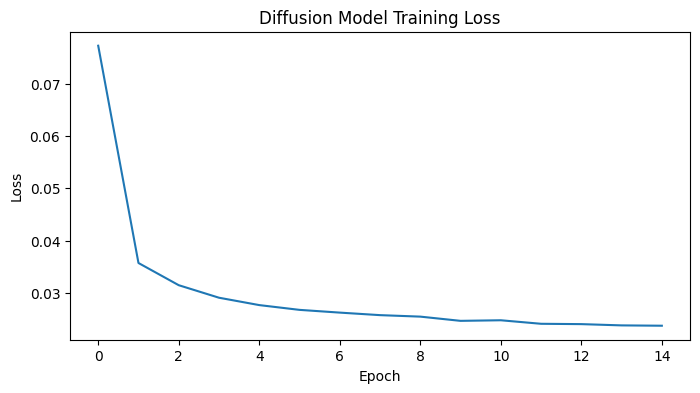

In [11]:
plt.figure(figsize=(8, 4))
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Diffusion Model Training Loss')
plt.show()

---
## 5. Sampling: DDPM

DDPM (Denoising Diffusion Probabilistic Models) sampling:

Starting from $x_T \sim \mathcal{N}(0, I)$, iteratively denoise:

$$x_{t-1} = \frac{1}{\sqrt{\alpha_t}} \left( x_t - \frac{\beta_t}{\sqrt{1-\bar{\alpha}_t}} \epsilon_\theta(x_t, t) \right) + \sigma_t z$$

where $z \sim \mathcal{N}(0, I)$ and $\sigma_t = \sqrt{\beta_t}$

In [12]:
@torch.no_grad()
def sample_ddpm(model, scheduler, n_samples=16, img_size=28, channels=1):
    """Generate samples using DDPM sampling."""
    model.eval()
    
    # Start from pure noise
    x = torch.randn(n_samples, channels, img_size, img_size, device=device)
    
    # Reverse diffusion
    for t in tqdm(reversed(range(scheduler.num_timesteps)), desc="Sampling"):
        t_batch = torch.full((n_samples,), t, device=device, dtype=torch.long)
        
        # Predict noise
        predicted_noise = model(x, t_batch)
        
        # Get scheduler parameters
        alpha = scheduler.alphas[t]
        alpha_cumprod = scheduler.alphas_cumprod[t]
        beta = scheduler.betas[t]
        
        # Compute x_{t-1}
        if t > 0:
            noise = torch.randn_like(x)
            sigma = torch.sqrt(beta)
        else:
            noise = torch.zeros_like(x)
            sigma = 0
        
        x = (1 / torch.sqrt(alpha)) * (x - (beta / torch.sqrt(1 - alpha_cumprod)) * predicted_noise)
        x = x + sigma * noise
    
    # Clamp to valid range
    x = torch.clamp(x, -1, 1)
    return x

Sampling: 1000it [00:03, 272.54it/s]


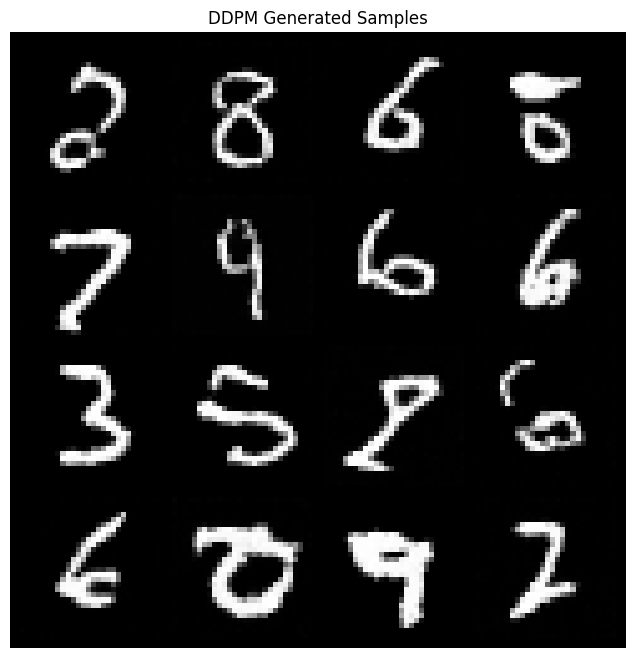

In [14]:
# Generate samples
samples = sample_ddpm(model, scheduler, n_samples=16)

# Visualize
samples = (samples + 1) / 2  # Denormalize to [0, 1]
grid = make_grid(samples, nrow=4, padding=2)

plt.figure(figsize=(8, 8))
plt.imshow(grid.cpu().permute(1, 2, 0).squeeze(), cmap='gray')
plt.axis('off')
plt.title('DDPM Generated Samples')
plt.show()

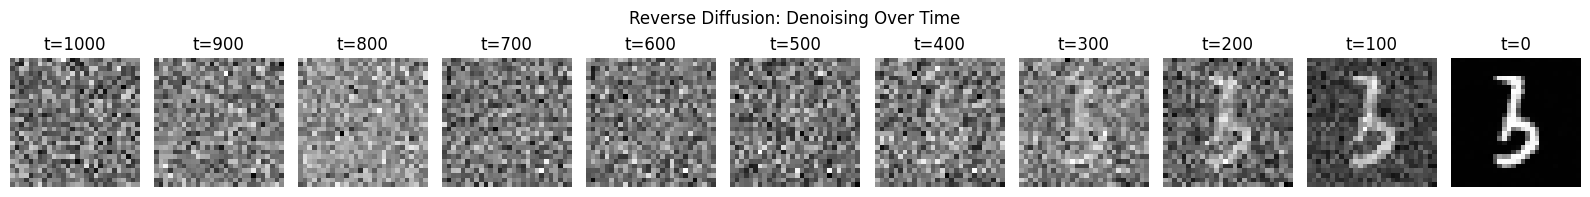

In [18]:
# Visualize the denoising process
@torch.no_grad()
def visualize_denoising(model, scheduler, save_every=100):
    """Visualize the reverse diffusion process."""
    model.eval()
    
    x = torch.randn(1, 1, 28, 28, device=device)
    images = [x.clone()]
    timesteps_saved = [scheduler.num_timesteps]
    
    for t in reversed(range(scheduler.num_timesteps)):
        t_batch = torch.full((1,), t, device=device, dtype=torch.long)
        predicted_noise = model(x, t_batch)
        
        alpha = scheduler.alphas[t]
        alpha_cumprod = scheduler.alphas_cumprod[t]
        beta = scheduler.betas[t]
        
        if t > 0:
            noise = torch.randn_like(x)
            sigma = torch.sqrt(beta)
        else:
            noise = torch.zeros_like(x)
            sigma = 0
        
        x = (1 / torch.sqrt(alpha)) * (x - (beta / torch.sqrt(1 - alpha_cumprod)) * predicted_noise)
        x = x + sigma * noise
        
        if t % save_every == 0 or t == 0:
            images.append(x.clone())
            timesteps_saved.append(t)
    
    return images, timesteps_saved

images, timesteps = visualize_denoising(model, scheduler, save_every=100)

fig, axes = plt.subplots(1, len(images), figsize=(16, 2))
for ax, img, t in zip(axes, images, timesteps):
    img = (img[0, 0].cpu() + 1) / 2
    ax.imshow(img, cmap='gray')
    ax.set_title(f't={t}')
    ax.axis('off')

plt.suptitle('Reverse Diffusion: Denoising Over Time')
plt.tight_layout()
plt.show()

---
## 6. Faster Sampling: DDIM

DDPM requires T steps (e.g., 1000). DDIM (Denoising Diffusion Implicit Models) enables faster sampling by skipping steps.

DDIM is deterministic (no noise added during sampling):
$$x_{t-1} = \sqrt{\bar{\alpha}_{t-1}} \hat{x}_0 + \sqrt{1 - \bar{\alpha}_{t-1}} \cdot \epsilon_\theta(x_t, t)$$

where $\hat{x}_0 = \frac{x_t - \sqrt{1-\bar{\alpha}_t} \epsilon_\theta(x_t, t)}{\sqrt{\bar{\alpha}_t}}$

In [19]:
@torch.no_grad()
def sample_ddim(model, scheduler, n_samples=16, num_inference_steps=50, 
                img_size=28, channels=1):
    """Generate samples using DDIM (faster, deterministic)."""
    model.eval()
    
    # Create timestep schedule (subset of training timesteps)
    step_size = scheduler.num_timesteps // num_inference_steps
    timesteps = list(range(0, scheduler.num_timesteps, step_size))
    timesteps = list(reversed(timesteps))
    
    # Start from pure noise
    x = torch.randn(n_samples, channels, img_size, img_size, device=device)
    
    for i, t in enumerate(tqdm(timesteps, desc="DDIM Sampling")):
        t_batch = torch.full((n_samples,), t, device=device, dtype=torch.long)
        
        # Predict noise
        predicted_noise = model(x, t_batch)
        
        # Get alpha values
        alpha_cumprod_t = scheduler.alphas_cumprod[t]
        
        if i + 1 < len(timesteps):
            t_prev = timesteps[i + 1]
            alpha_cumprod_t_prev = scheduler.alphas_cumprod[t_prev]
        else:
            alpha_cumprod_t_prev = torch.tensor(1.0, device=device)
        
        # Predict x_0
        pred_x0 = (x - torch.sqrt(1 - alpha_cumprod_t) * predicted_noise) / torch.sqrt(alpha_cumprod_t)
        pred_x0 = torch.clamp(pred_x0, -1, 1)
        
        # DDIM update (deterministic)
        x = torch.sqrt(alpha_cumprod_t_prev) * pred_x0 + \
            torch.sqrt(1 - alpha_cumprod_t_prev) * predicted_noise
    
    return torch.clamp(x, -1, 1)

DDIM Sampling: 100%|██████████| 50/50 [00:00<00:00, 270.85it/s]


DDIM (50 steps): 0.19s


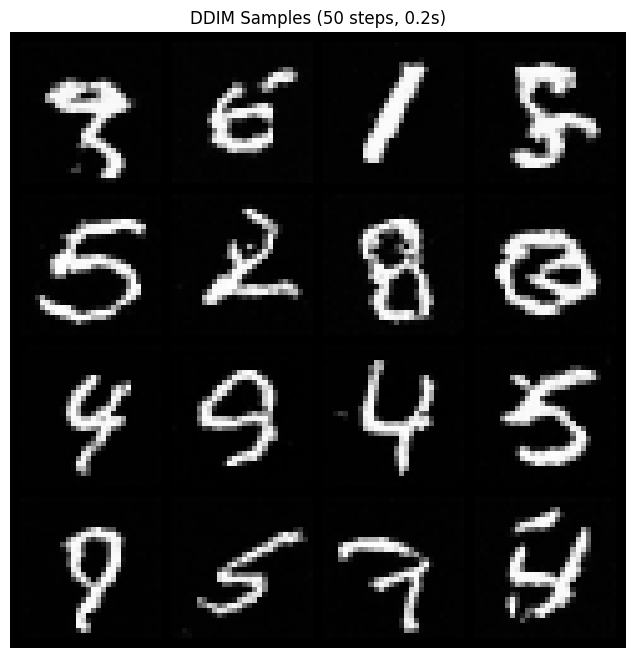

In [22]:
# Compare DDPM (1000 steps) vs DDIM (50 steps)
import time

# DDIM sampling (fast)
start = time.time()
samples_ddim = sample_ddim(model, scheduler, n_samples=16, num_inference_steps=50)
ddim_time = time.time() - start

print(f"DDIM (50 steps): {ddim_time:.2f}s")

# Visualize
samples_ddim = (samples_ddim + 1) / 2
grid = make_grid(samples_ddim, nrow=4, padding=2)

plt.figure(figsize=(8, 8))
plt.imshow(grid.cpu().permute(1, 2, 0).squeeze(), cmap='gray')
plt.axis('off')
plt.title(f'DDIM Samples (50 steps, {ddim_time:.1f}s)')
plt.show()

DDIM Sampling:   0%|          | 0/10 [00:00<?, ?it/s]

DDIM Sampling: 100%|██████████| 100/100 [00:00<00:00, 618.97it/s]


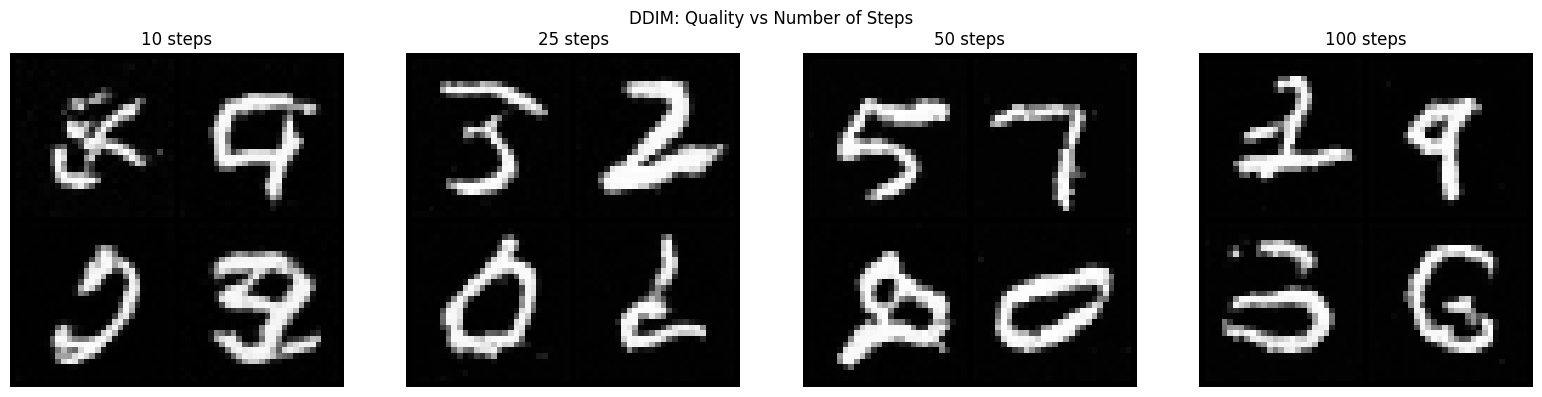

In [24]:
# Compare quality at different step counts
step_counts = [10, 25, 50, 100]

fig, axes = plt.subplots(1, len(step_counts), figsize=(16, 4))

for ax, steps in zip(axes, step_counts):
    samples = sample_ddim(model, scheduler, n_samples=4, num_inference_steps=steps)
    samples = (samples + 1) / 2
    grid = make_grid(samples, nrow=2, padding=1)
    ax.imshow(grid.cpu().permute(1, 2, 0).squeeze(), cmap='gray')
    ax.set_title(f'{steps} steps')
    ax.axis('off')

plt.suptitle('DDIM: Quality vs Number of Steps')
plt.tight_layout()
plt.show()

---
## 7. Cosine Schedule (Improved)

The linear schedule degrades images too quickly. A cosine schedule provides smoother noise addition.

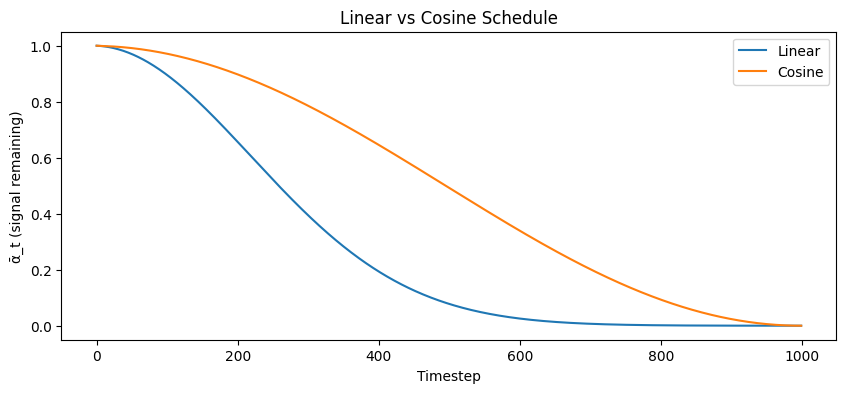

In [25]:
class CosineNoiseScheduler(NoiseScheduler):
    """Cosine noise schedule (from 'Improved DDPM')."""
    
    def __init__(self, num_timesteps=1000, s=0.008, device='cpu'):
        self.num_timesteps = num_timesteps
        self.device = device
        
        # Cosine schedule
        steps = torch.linspace(0, num_timesteps, num_timesteps + 1, device=device)
        alphas_cumprod = torch.cos(((steps / num_timesteps) + s) / (1 + s) * np.pi * 0.5) ** 2
        alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
        
        betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
        self.betas = torch.clamp(betas, 0.0001, 0.9999)
        
        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        self.alphas_cumprod_prev = F.pad(self.alphas_cumprod[:-1], (1, 0), value=1.0)
        
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - self.alphas_cumprod)
        self.posterior_variance = self.betas * (1.0 - self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)

# Compare schedules
linear_sched = NoiseScheduler(1000, device=device)
cosine_sched = CosineNoiseScheduler(1000, device=device)

plt.figure(figsize=(10, 4))
plt.plot(linear_sched.alphas_cumprod.cpu(), label='Linear')
plt.plot(cosine_sched.alphas_cumprod.cpu(), label='Cosine')
plt.xlabel('Timestep')
plt.ylabel('ᾱ_t (signal remaining)')
plt.title('Linear vs Cosine Schedule')
plt.legend()
plt.show()

---
## 8. Summary

### Key Concepts

| Concept | Description |
|---------|-------------|
| **Forward Process** | Add noise gradually: $x_t = \sqrt{\bar{\alpha}_t} x_0 + \sqrt{1-\bar{\alpha}_t} \epsilon$ |
| **Reverse Process** | Learn to denoise step by step |
| **Training Objective** | Predict the noise: $\|\epsilon - \epsilon_\theta(x_t, t)\|^2$ |
| **U-Net** | Encoder-decoder with skip connections and time embedding |
| **DDPM Sampling** | Stochastic, requires T steps |
| **DDIM Sampling** | Deterministic, can skip steps |

### Diffusion vs GANs vs VAEs

| Aspect | Diffusion | GAN | VAE |
|--------|-----------|-----|-----|
| Training | Stable | Unstable | Stable |
| Quality | Excellent | Excellent | Good (blurry) |
| Speed | Slow sampling | Fast | Fast |
| Mode coverage | Good | Mode collapse risk | Good |

### Modern Extensions
- **Latent Diffusion (Stable Diffusion)**: Run diffusion in VAE latent space
- **Classifier-Free Guidance**: Condition generation without separate classifier
- **ControlNet**: Add spatial conditioning (edges, poses)

---
## Exercises

### Exercise 1: Conditional Diffusion
Modify the model to condition on class labels for generating specific digits.

### Exercise 2: Cosine Schedule Training
Retrain with the cosine schedule and compare sample quality.

### Exercise 3: Interpolation in Noise Space
Implement spherical interpolation (slerp) between two noise vectors and generate the interpolated images.

---
## Solutions

Training conditional diffusion model...
Epoch 1, Loss: 0.0815
Epoch 2, Loss: 0.0357
Epoch 3, Loss: 0.0313
Epoch 4, Loss: 0.0288
Epoch 5, Loss: 0.0272
Epoch 6, Loss: 0.0261
Epoch 7, Loss: 0.0253
Epoch 8, Loss: 0.0248
Epoch 9, Loss: 0.0244
Epoch 10, Loss: 0.0242


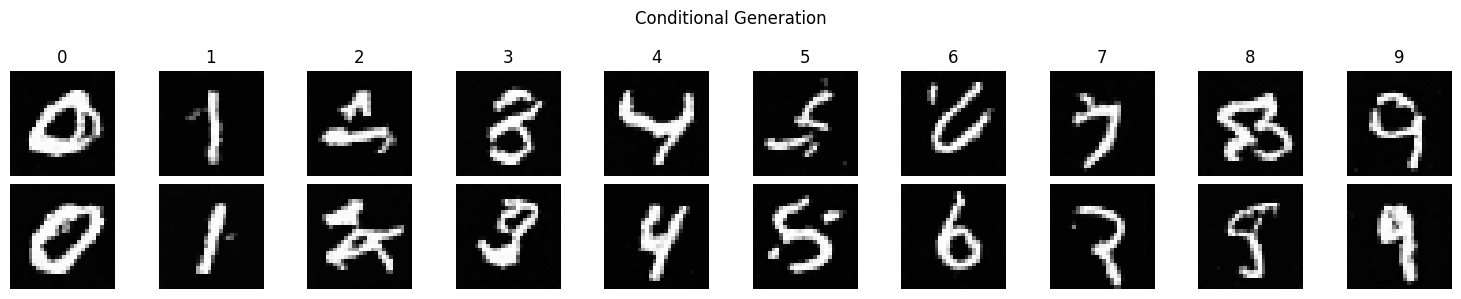

In [26]:
# Solution 1: Conditional Diffusion
class ConditionalUNet(nn.Module):
    """U-Net with class conditioning."""
    
    def __init__(self, in_channels=1, base_channels=64, time_emb_dim=128, num_classes=10):
        super().__init__()
        
        # Time + class embedding
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.SiLU(),
            nn.Linear(time_emb_dim, time_emb_dim)
        )
        self.class_emb = nn.Embedding(num_classes, time_emb_dim)
        
        # Same architecture as before
        self.conv_in = nn.Conv2d(in_channels, base_channels, 3, padding=1)
        self.down1 = ResBlock(base_channels, base_channels, time_emb_dim)
        self.down2 = ResBlock(base_channels, base_channels * 2, time_emb_dim)
        self.pool = nn.MaxPool2d(2)
        self.bot1 = ResBlock(base_channels * 2, base_channels * 4, time_emb_dim)
        self.bot2 = ResBlock(base_channels * 4, base_channels * 2, time_emb_dim)
        self.up = nn.Upsample(scale_factor=2, mode='nearest')
        self.up1 = ResBlock(base_channels * 4, base_channels, time_emb_dim)
        self.up2 = ResBlock(base_channels * 2, base_channels, time_emb_dim)
        self.conv_out = nn.Conv2d(base_channels, in_channels, 1)
    
    def forward(self, x, t, y):
        # Combine time and class embeddings
        t_emb = self.time_mlp(t) + self.class_emb(y)
        
        x1 = self.conv_in(x)
        x1 = self.down1(x1, t_emb)
        x2 = self.pool(x1)
        x2 = self.down2(x2, t_emb)
        x3 = self.pool(x2)
        x3 = self.bot1(x3, t_emb)
        x3 = self.bot2(x3, t_emb)
        x = self.up(x3)
        x = torch.cat([x, x2], dim=1)
        x = self.up1(x, t_emb)
        x = self.up(x)
        x = torch.cat([x, x1], dim=1)
        x = self.up2(x, t_emb)
        return self.conv_out(x)

# Train conditional model
cond_model = ConditionalUNet(base_channels=64).to(device)
optimizer = torch.optim.Adam(cond_model.parameters(), lr=2e-4)

print("Training conditional diffusion model...")
for epoch in range(10):
    epoch_loss = 0
    for x_0, y in train_loader:
        x_0, y = x_0.to(device), y.to(device)
        t = scheduler.sample_timesteps(x_0.size(0))
        noise = torch.randn_like(x_0)
        x_t = scheduler.add_noise(x_0, t, noise)
        
        predicted_noise = cond_model(x_t, t, y)
        loss = F.mse_loss(predicted_noise, noise)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {epoch_loss/len(train_loader):.4f}")

# Generate specific digits
@torch.no_grad()
def sample_conditional(model, scheduler, labels, num_steps=50):
    model.eval()
    n = len(labels)
    x = torch.randn(n, 1, 28, 28, device=device)
    labels = labels.to(device)
    
    step_size = scheduler.num_timesteps // num_steps
    timesteps = list(reversed(range(0, scheduler.num_timesteps, step_size)))
    
    for i, t in enumerate(timesteps):
        t_batch = torch.full((n,), t, device=device, dtype=torch.long)
        pred_noise = model(x, t_batch, labels)
        
        alpha_cumprod_t = scheduler.alphas_cumprod[t]
        alpha_cumprod_t_prev = scheduler.alphas_cumprod[timesteps[i+1]] if i+1 < len(timesteps) else torch.tensor(1.0)
        
        pred_x0 = (x - torch.sqrt(1 - alpha_cumprod_t) * pred_noise) / torch.sqrt(alpha_cumprod_t)
        pred_x0 = torch.clamp(pred_x0, -1, 1)
        x = torch.sqrt(alpha_cumprod_t_prev) * pred_x0 + torch.sqrt(1 - alpha_cumprod_t_prev) * pred_noise
    
    return torch.clamp(x, -1, 1)

# Generate each digit
labels = torch.arange(10).repeat(2)  # 2 samples per digit
samples = sample_conditional(cond_model, scheduler, labels, num_steps=50)
samples = (samples + 1) / 2

fig, axes = plt.subplots(2, 10, figsize=(15, 3))
for i in range(20):
    ax = axes[i // 10, i % 10]
    ax.imshow(samples[i, 0].cpu(), cmap='gray')
    ax.axis('off')
    if i < 10:
        ax.set_title(str(i))
plt.suptitle('Conditional Generation')
plt.tight_layout()
plt.show()

Training with cosine schedule...


Epoch 1/10: 100%|██████████| 468/468 [00:41<00:00, 11.26it/s, loss=0.0636]


Epoch 1 - Average Loss: 0.1114


Epoch 2/10: 100%|██████████| 468/468 [00:41<00:00, 11.35it/s, loss=0.0534]


Epoch 2 - Average Loss: 0.0575


Epoch 3/10: 100%|██████████| 468/468 [00:41<00:00, 11.31it/s, loss=0.0543]


Epoch 3 - Average Loss: 0.0512


Epoch 4/10: 100%|██████████| 468/468 [00:41<00:00, 11.19it/s, loss=0.0478]


Epoch 4 - Average Loss: 0.0481


Epoch 5/10: 100%|██████████| 468/468 [00:42<00:00, 11.03it/s, loss=0.0505]


Epoch 5 - Average Loss: 0.0464


Epoch 6/10: 100%|██████████| 468/468 [00:41<00:00, 11.15it/s, loss=0.0394]


Epoch 6 - Average Loss: 0.0450


Epoch 7/10: 100%|██████████| 468/468 [00:42<00:00, 11.13it/s, loss=0.0509]


Epoch 7 - Average Loss: 0.0440


Epoch 8/10: 100%|██████████| 468/468 [00:42<00:00, 11.14it/s, loss=0.0386]


Epoch 8 - Average Loss: 0.0434


Epoch 9/10: 100%|██████████| 468/468 [00:41<00:00, 11.18it/s, loss=0.0379]


Epoch 9 - Average Loss: 0.0425


Epoch 10/10: 100%|██████████| 468/468 [00:41<00:00, 11.32it/s, loss=0.0399]


Epoch 10 - Average Loss: 0.0419


DDIM Sampling: 100%|██████████| 50/50 [00:00<00:00, 264.52it/s]


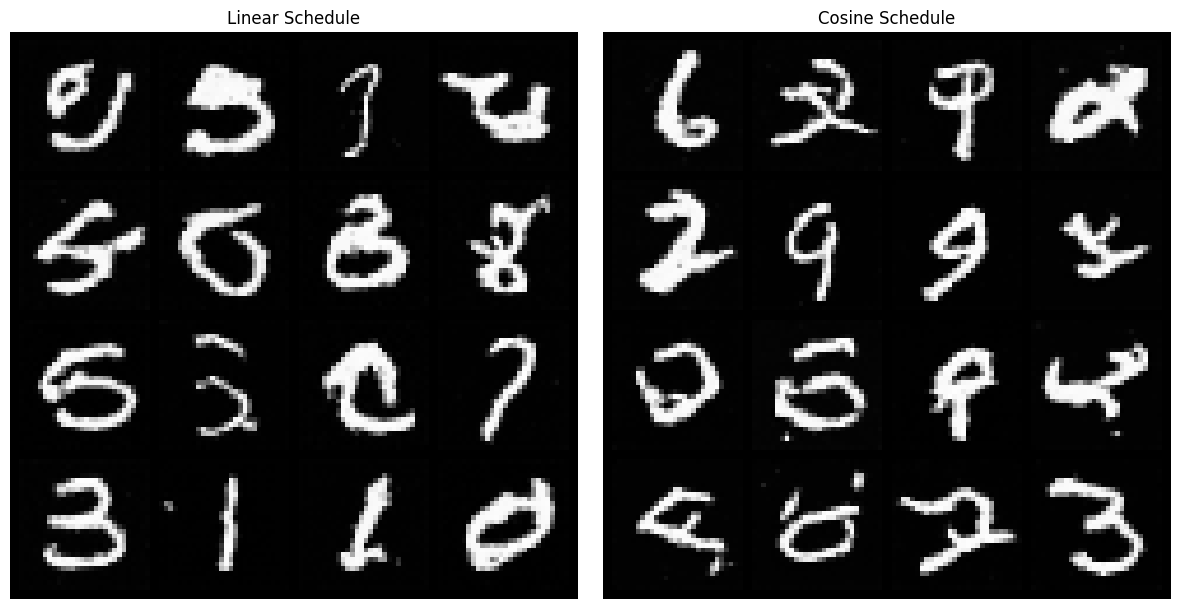

In [27]:
# Solution 2: Cosine Schedule Training
cosine_scheduler = CosineNoiseScheduler(num_timesteps=1000, device=device)
cosine_model = SimpleUNet(base_channels=64).to(device)

print("Training with cosine schedule...")
cosine_losses = train_diffusion(cosine_model, cosine_scheduler, train_loader, epochs=10, lr=2e-4)

# Compare samples
samples_cosine = sample_ddim(cosine_model, cosine_scheduler, n_samples=16, num_inference_steps=50)
samples_cosine = (samples_cosine + 1) / 2

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Linear schedule samples (from earlier)
samples_linear = sample_ddim(model, scheduler, n_samples=16, num_inference_steps=50)
samples_linear = (samples_linear + 1) / 2

grid_linear = make_grid(samples_linear, nrow=4, padding=2)
grid_cosine = make_grid(samples_cosine, nrow=4, padding=2)

axes[0].imshow(grid_linear.cpu().permute(1, 2, 0).squeeze(), cmap='gray')
axes[0].set_title('Linear Schedule')
axes[0].axis('off')

axes[1].imshow(grid_cosine.cpu().permute(1, 2, 0).squeeze(), cmap='gray')
axes[1].set_title('Cosine Schedule')
axes[1].axis('off')

plt.tight_layout()
plt.show()

In [29]:
# Solution 3: Spherical Interpolation (Slerp)
def slerp(z1, z2, alpha):
    """Spherical linear interpolation between two noise vectors."""
    z1_norm = z1 / z1.norm(dim=[1,2,3], keepdim=True)
    z2_norm = z2 / z2.norm(dim=[1,2,3], keepdim=True)
    
    # Compute angle
    dot = (z1_norm * z2_norm).sum(dim=[1,2,3], keepdim=True).clamp(-1, 1)
    omega = torch.acos(dot)
    
    # Slerp formula
    so = torch.sin(omega)
    z = (torch.sin((1 - alpha) * omega) / so) * z1 + (torch.sin(alpha * omega) / so) * z2
    
    return z

@torch.no_grad()
def interpolate_noise(model, scheduler, n_interp=10, num_steps=50):
    """Generate interpolated samples between two noise vectors."""
    model.eval()
    
    # Two random noise vectors
    z1 = torch.randn(1, 1, 28, 28, device=device)
    z2 = torch.randn(1, 1, 28, 28, device=device)
    
    images = []
    alphas = torch.linspace(0, 1, n_interp)
    
    for alpha in alphas:
        # Interpolate in noise space
        z = slerp(z1, z2, alpha)
        
        # Denoise
        x = z.clone()
        step_size = scheduler.num_timesteps // num_steps
        timesteps = list(reversed(range(0, scheduler.num_timesteps, step_size)))
        
        for i, t in enumerate(timesteps):
            t_batch = torch.full((1,), t, device=device, dtype=torch.long)
            pred_noise = model(x, t_batch)
            
            alpha_cumprod_t = scheduler.alphas_cumprod[t]
            alpha_cumprod_t_prev = scheduler.alphas_cumprod[timesteps[i+1]] if i+1 < len(timesteps) else torch.tensor(1.0)
            
            pred_x0 = (x - torch.sqrt(1 - alpha_cumprod_t) * pred_noise) / torch.sqrt(alpha_cumprod_t)
            pred_x0 = torch.clamp(pred_x0, -1, 1)
            x = torch.sqrt(alpha_cumprod_t_prev) * pred_x0 + torch.sqrt(1 - alpha_cumprod_t_prev) * pred_noise
        
        images.append(torch.clamp(x, -1, 1))
    
    return torch.cat(images)

# Generate interpolation
interp_samples = interpolate_noise(model, scheduler, n_interp=10, num_steps=50)
interp_samples = (interp_samples + 1) / 2

fig, axes = plt.subplots(1, 10, figsize=(15, 1.5))
for i, ax in enumerate(axes):
    ax.imshow(interp_samples[i, 0].cpu(), cmap='gray')
    ax.axis('off')
plt.suptitle('Spherical Interpolation in Noise Space')
plt.tight_layout()
plt.show()

RuntimeError: linalg.matrix_norm: dim must be a 2-tuple. Got 1 2 3